In [149]:
import pandas as pd
import collections as c
from collections import Counter
import re
import csv

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import sys
from nltk.tokenize import word_tokenize

import sklearn
import matplotlib.pyplot as plt
import wordcloud
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv('Food_Inspections.csv')

In [7]:
#get data for passes and fails
PassFail = df["Results"].isin (["Fail","Pass"])

PassFailed = df.loc[PassFail]


In [10]:
PassFailed

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
35,2370354,SLIM'S,SLIM'S,2622236.0,Restaurant,Risk 1 (High),2020 W MONTROSE AVE,CHICAGO,IL,60618.0,05/08/2020,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.961556,-87.679862,"(-87.67986227331792, 41.96155579127668)"
41,2369855,Chicago Prep Master Tenant LLC,Chicago Prep Master Tenant,2723671.0,Shared Kitchen,Risk 1 (High),5801 W Dickens AVE,CHICAGO,IL,60639.0,04/28/2020,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.917869,-87.770697,"(-87.77069733431132, 41.91786924215764)"
48,2369400,DSD DELI,DSD DELI,2626178.0,DELI/GROCERY,Risk 1 (High),5205 N MILWAUKEE,CHICAGO,IL,60630.0,04/17/2020,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.974849,-87.766829,"(-87.76682905043768, 41.97484853157327)"
49,2369394,AMSTAR,AMSTAR,2152845.0,Grocery Store,Risk 2 (Medium),8950-58 S ASHLAND AVE,CHICAGO,IL,60620.0,04/17/2020,Canvass Re-Inspection,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.730593,-87.663058,"(-87.66305762988213, 41.730593381254266)"
59,2366945,RED SNAPPER,JIMMY'S BEST,2232836.0,Restaurant,Risk 1 (High),1347 E 87TH ST,CHICAGO,IL,60619.0,04/08/2020,Canvass Re-Inspection,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.736731,-87.591144,"(-87.59114387212324, 41.736730601766894)"
60,2367007,LA ROCCIA,LA ROCCIA,10486.0,Restaurant,Risk 1 (High),1909 N LINCOLN AVE,CHICAGO,IL,60614.0,04/09/2020,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.916848,-87.636524,"(-87.6365244655254, 41.91684810981031)"
64,2366716,JOJI GYROS,JOJI GYROS,2179843.0,Restaurant,Risk 1 (High),2518 E 79TH ST,CHICAGO,IL,60649.0,04/01/2020,Canvass Re-Inspection,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.751883,-87.562995,"(-87.56299535958054, 41.751883323857825)"
67,2366472,POKE POKE,POKE POKE,2574871.0,Restaurant,Risk 1 (High),802 W BELMONT AVE,CHICAGO,IL,60657.0,03/27/2020,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.940089,-87.649391,"(-87.64939125456559, 41.94008901097665)"
99,2362705,GORDITAS LA TIA,GORDITAS LA TIA,2713298.0,Restaurant,Risk 1 (High),6425 W 63RD ST,CHICAGO,IL,60638.0,02/21/2020,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.777550,-87.782265,"(-87.78226491921245, 41.77755027536734)"
102,2362293,TROQUET RIVER NORTH,TROQUET,1954838.0,Restaurant,Risk 1 (High),111 W HURON ST,CHICAGO,IL,60654.0,02/13/2020,Canvass Re-Inspection,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.894716,-87.631716,"(-87.63171614204819, 41.8947160042679)"


In [9]:
PassFailed = PassFailed.dropna(subset=['Violations'])
PassFailed = PassFailed[PassFailed['Violations'].astype(bool)] 

### Get Violations Info

In [12]:
violation_master_list = []
f = lambda x: x['Violations'].split("|")
violation_list = PassFailed.apply(f, axis=1)

In [13]:
flat_list = [item for sublist in violation_list for item in sublist]

In [16]:
flat_list

['1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES - Comments: PERSON IN CHARGE DOES NOT HAVE A CITY OF CHICAGO SANITATION CERTIFICATE. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. ',
 ' 2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CITY OF CHICAGO CERTIFIED FOOD MANAGER ON SITE WHILE TCS FOODS ARE BEING PREPARED AND SERVED SUCH AS ROAST BEEF AT 40.1F. PRIORITY FOUNDATION VIOLATION 7-38-012. NO CITATION ISSUED. ',
 ' 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: NO WRITTEN EMPLOYEE HEALTH POLICY ON SITE. MUST PROVIDE. PRIORITY FOUNDATION VIOLATION 7-38-010. NO CITATION ISSUED. ',
 ' 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO WRITTEN CLEANING PROCEDURE OR REQUIRED EQUIPMENT FOR A VOMITING/DIARRHEA EVENT. MUST PROVIDE. PRIORITY FOUNDATION VIOLATION 7-38-005. NO CITATION ISSUED. ',
 ' 9. NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-APPROVED 

In [17]:
x = []
pattern = r"(?:Comments:)(.*)"

for i in flat_list:
     result = re.findall(pattern,str(i)) #perform regex & identify/extract the violation code only
     x.append(result)#append the violation code into violation_master_list


In [18]:
x

[[' PERSON IN CHARGE DOES NOT HAVE A CITY OF CHICAGO SANITATION CERTIFICATE. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. '],
 [' NO CITY OF CHICAGO CERTIFIED FOOD MANAGER ON SITE WHILE TCS FOODS ARE BEING PREPARED AND SERVED SUCH AS ROAST BEEF AT 40.1F. PRIORITY FOUNDATION VIOLATION 7-38-012. NO CITATION ISSUED. '],
 [' NO WRITTEN EMPLOYEE HEALTH POLICY ON SITE. MUST PROVIDE. PRIORITY FOUNDATION VIOLATION 7-38-010. NO CITATION ISSUED. '],
 [' NO WRITTEN CLEANING PROCEDURE OR REQUIRED EQUIPMENT FOR A VOMITING/DIARRHEA EVENT. MUST PROVIDE. PRIORITY FOUNDATION VIOLATION 7-38-005. NO CITATION ISSUED. '],
 [' OBSERVED BARE HAND CONTACT WITH READY TO EAT FOODS. COOK OBSERVED HANDLING READY TO EAT BREAD AND CHOPPED READY TO EAT BACON WITH ONE BARE HAND AND ONE GLOVED HAND. INSTRUCTED NO BARE HAND CONTACT WITH READY TO EAT FOODS. PRIORITY VIOLATION 7-38-010. NO CITATION ISSUED. '],
 [' NO PAPER TOWELS OR HAND DRYING DEVICE IN THE EMPLOYEE WASHROOM. MUST PROVIDE AT ALL TIMES. PRIORITY FO

In [49]:
flat_x = [item for sublist in x for item in sublist]

In [22]:
reg_list = [str(i) for i in x]

In [23]:
words = []

for i in reg_list:
    res = word_tokenize(i)
    words.append(res)

In [24]:
fdist = []

for i in words:
    res = nltk.FreqDist(i)
    fdist.append(res)

In [25]:
print(fdist[1:10])

[FreqDist({'.': 3, "'": 2, 'NO': 2, '[': 1, 'CITY': 1, 'OF': 1, 'CHICAGO': 1, 'CERTIFIED': 1, 'FOOD': 1, 'MANAGER': 1, ...}), FreqDist({'.': 4, "'": 2, 'NO': 2, '[': 1, 'WRITTEN': 1, 'EMPLOYEE': 1, 'HEALTH': 1, 'POLICY': 1, 'ON': 1, 'SITE': 1, ...}), FreqDist({'.': 4, "'": 2, 'NO': 2, '[': 1, 'WRITTEN': 1, 'CLEANING': 1, 'PROCEDURE': 1, 'OR': 1, 'REQUIRED': 1, 'EQUIPMENT': 1, ...}), FreqDist({'.': 5, 'HAND': 4, 'READY': 4, 'TO': 4, 'EAT': 4, 'BARE': 3, 'WITH': 3, "'": 2, 'OBSERVED': 2, 'CONTACT': 2, ...}), FreqDist({'.': 3, "'": 2, 'NO': 2, '[': 1, 'PAPER': 1, 'TOWELS': 1, 'OR': 1, 'HAND': 1, 'DRYING': 1, 'DEVICE': 1, ...}), FreqDist({'.': 5, "'": 2, 'TO': 2, 'LETTUCE': 2, '[': 1, 'OBSERVED': 1, 'RAW': 1, 'ANIMAL': 1, 'ORIGIN': 1, 'EGGS': 1, ...}), FreqDist({'.': 5, "'": 2, 'SAUCE': 2, 'HELD': 2, 'A': 2, 'HOT': 2, 'AT': 2, 'TEMPERATURE': 2, 'OF': 2, '[': 1, ...}), FreqDist({'.': 5, ',': 4, 'DATE': 3, 'NO': 3, "'": 2, 'PREPARED': 2, 'TCS': 2, 'FOODS': 2, 'PROPERLY': 2, 'LABELED': 2, ...

In [26]:
word_list = [item for sublist in fdist for item in sublist]

In [27]:
RawTokens=Counter(word_list).most_common(10) 
RawTokens

[('[', 533739),
 (']', 533739),
 ("'", 519929),
 ('.', 496027),
 ('AND', 293719),
 ('IN', 248040),
 ('TO', 238806),
 (',', 218809),
 ('MUST', 204868),
 ('THE', 178151)]

In [28]:
stopwords = set(nltk.corpus.stopwords.words('english'))
words = [word for word in word_list if len(word) > 1]

In [29]:
# Remove stopwords
words = [word for word in words if word not in stopwords]

In [30]:
fdist_cleaned = nltk.FreqDist(words)
CleanedTokens = Counter(fdist_cleaned).most_common(10)
CleanedTokens

[('AND', 293719),
 ('IN', 248040),
 ('TO', 238806),
 ('MUST', 204868),
 ('THE', 178151),
 ('CLEAN', 161852),
 ('INSTRUCTED', 156403),
 ('OF', 145032),
 ('AREA', 123737),
 ('MAINTAIN', 121465)]

In [21]:
wnl = nltk.WordNetLemmatizer()

In [31]:
print([wnl.lemmatize(t) for t in words[0:50]])

['PERSON', 'IN', 'CHARGE', 'DOES', 'NOT', 'HAVE', 'CITY', 'OF', 'CHICAGO', 'SANITATION', 'CERTIFICATE', 'PRIORITY', 'FOUNDATION', 'VIOLATION', 'NO', 'CITATION', 'ISSUED', 'NO', 'CITY', 'OF', 'CHICAGO', 'CERTIFIED', 'FOOD', 'MANAGER', 'ON', 'SITE', 'WHILE', 'TCS', 'FOODS', 'ARE', 'BEING', 'PREPARED', 'AND', 'SERVED', 'SUCH', 'AS', 'ROAST', 'BEEF', 'AT', '40.1F', 'PRIORITY', 'FOUNDATION', 'VIOLATION', '7-38-012', 'CITATION', 'ISSUED', 'NO', 'WRITTEN', 'EMPLOYEE', 'HEALTH']


In [32]:
Lemmatize =[wnl.lemmatize(t) for t in words[0:]]
Lemmatize_tokens = nltk.FreqDist(Lemmatize)
LemmatizeTokens = Lemmatize_tokens.most_common(10)
LemmatizeTokens 

[('AND', 293719),
 ('IN', 248040),
 ('TO', 238806),
 ('MUST', 204868),
 ('THE', 178151),
 ('CLEAN', 161852),
 ('INSTRUCTED', 156403),
 ('OF', 145032),
 ('AREA', 123737),
 ('MAINTAIN', 121465)]

# Count Vectorizer

In [66]:
countvectorizer = CountVectorizer()
countvectorizer_matrix = countvectorizer.fit_transform(flat_x)
countvectorizer_matrix.shape

(532952, 40070)

In [67]:
countvectorizer = CountVectorizer(stop_words='english')
countvectorizer_matrix = countvectorizer.fit_transform(flat_x)
countvectorizer_matrix.shape

(532952, 39792)

In [71]:
countvectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))
#countvectorizer = CountVectorizer(analyzer='char', ngram_range=(1,3))
#countvectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,3))
countvectorizer_matrix = countvectorizer.fit_transform(flat_x)
countvectorizer_matrix.shape

(532952, 2232130)

In [73]:
countvectorizer = CountVectorizer(lowercase=False, stop_words='english',
                                  max_df=0.8, min_df=0.2, max_features=1000, ngram_range=(1,3))
countvectorizer_matrix = countvectorizer.fit_transform(flat_x)
countvectorizer_matrix.shape

(532952, 16)

In [58]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names())
countvectorizer_matrix_df

,ALL,AND,AND MAINTAIN,AREA,AT,CLEAN,IN,INSTRUCTED,INSTRUCTED TO,MAINTAIN,MUST,OBSERVED,OF,ON,THE,TO
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,2,0,0,0,0,0,1,0,0,0,2,0,0,0,4
5,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
6,1,0,0,0,0,0,2,1,1,0,0,1,0,1,0,2
7,1,0,0,0,2,0,1,1,0,0,1,1,2,0,0,0
8,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1
9,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1


# Hashing Vectorizer

In [59]:
hashingvectorizer = HashingVectorizer(n_features=15)
hashingvectorizer_matrix = hashingvectorizer.fit_transform(flat_x)
hashingvectorizer_matrix.shape

(532952, 15)

In [60]:
hashingvectorizer_matrix_df = pd.DataFrame(hashingvectorizer_matrix.toarray())
hashingvectorizer_matrix_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.000000,0.000000,0.258199,0.516398,0.000000,0.000000,-0.258199,0.000000,0.000000,0.258199,0.516398,0.000000,-0.516398,0.000000
1,-0.223607,0.223607,-0.223607,0.223607,0.000000,-0.223607,0.223607,-0.447214,0.000000,-0.223607,0.223607,0.447214,0.000000,-0.447214,0.000000
2,-0.229416,0.229416,0.000000,0.000000,0.000000,0.000000,-0.229416,0.000000,0.000000,0.688247,0.458831,0.229416,0.229416,-0.229416,0.000000
3,0.000000,0.192450,0.000000,-0.192450,0.000000,0.192450,-0.192450,-0.192450,0.000000,0.384900,0.577350,0.384900,0.000000,-0.384900,0.192450
4,-0.371391,0.185695,0.000000,0.000000,0.000000,0.742781,0.185695,0.000000,0.000000,0.000000,-0.185695,0.185695,0.000000,0.185695,-0.371391
5,-0.176777,0.353553,0.000000,-0.176777,0.176777,0.000000,-0.353553,-0.353553,-0.176777,0.176777,0.530330,0.353553,0.176777,-0.176777,0.000000
6,0.000000,0.333333,0.166667,0.000000,0.500000,0.333333,0.000000,-0.166667,0.166667,-0.166667,0.333333,0.166667,0.500000,-0.166667,0.000000
7,-0.134840,-0.404520,0.269680,-0.134840,0.269680,0.134840,0.134840,-0.134840,0.269680,-0.134840,0.134840,0.404520,0.134840,0.134840,0.539360
8,-0.103695,-0.103695,-0.103695,0.414781,0.000000,0.207390,0.000000,0.000000,-0.103695,-0.207390,0.000000,0.829561,0.000000,-0.103695,0.000000
9,0.000000,0.223607,-0.223607,-0.223607,0.894427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000,0.000000,0.000000


In [61]:
tfidfvectorizer = TfidfVectorizer(stop_words='english')
tfidfvectorizer_matrix = tfidfvectorizer.fit_transform(flat_x)
tfidfvectorizer_matrix.shape

(532952, 39792)

In [62]:
tfidfvectorizer_matrix_df = pd.DataFrame(tfidfvectorizer_matrix.toarray(), columns=tfidfvectorizer.get_feature_names())
tfidfvectorizer_matrix_df

MemoryError: 

In [64]:
# instantiate CountVectorizer (we will use default parameters)
countvectorizer = CountVectorizer()
# learn the 'vocabulary' of the training data (occurs in-place)
countvectorizer.fit(flat_x)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
countvectorizer.get_feature_names()

['ALL',
 'AND',
 'AND MAINTAIN',
 'AREA',
 'AT',
 'CLEAN',
 'IN',
 'INSTRUCTED',
 'INSTRUCTED TO',
 'MAINTAIN',
 'MUST',
 'OBSERVED',
 'OF',
 'ON',
 'THE',
 'TO']

# Reading dataset into pandas

For my model, I'm including rows where the result is either "Fail", "Pass", or "Pass w/ Conditions" because those are the only outcomes that seem to have info in the "Violations" column.

In [80]:

PassFail = df["Results"].isin (["Fail","Pass","Pass w/ Conditions"])

inspections = df.loc[PassFail]

In [82]:
inspections = inspections.dropna(subset=['Violations'])
inspections = inspections[inspections['Violations'].astype(bool)] 

In [86]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,results_flag
35,2370354,SLIM'S,SLIM'S,2622236.0,Restaurant,Risk 1 (High),2020 W MONTROSE AVE,CHICAGO,IL,60618.0,05/08/2020,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.961556,-87.679862,"(-87.67986227331792, 41.96155579127668)",2
41,2369855,Chicago Prep Master Tenant LLC,Chicago Prep Master Tenant,2723671.0,Shared Kitchen,Risk 1 (High),5801 W Dickens AVE,CHICAGO,IL,60639.0,04/28/2020,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.917869,-87.770697,"(-87.77069733431132, 41.91786924215764)",2
48,2369400,DSD DELI,DSD DELI,2626178.0,DELI/GROCERY,Risk 1 (High),5205 N MILWAUKEE,CHICAGO,IL,60630.0,04/17/2020,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.974849,-87.766829,"(-87.76682905043768, 41.97484853157327)",2
49,2369394,AMSTAR,AMSTAR,2152845.0,Grocery Store,Risk 2 (Medium),8950-58 S ASHLAND AVE,CHICAGO,IL,60620.0,04/17/2020,Canvass Re-Inspection,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.730593,-87.663058,"(-87.66305762988213, 41.730593381254266)",2
59,2366945,RED SNAPPER,JIMMY'S BEST,2232836.0,Restaurant,Risk 1 (High),1347 E 87TH ST,CHICAGO,IL,60619.0,04/08/2020,Canvass Re-Inspection,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.736731,-87.591144,"(-87.59114387212324, 41.736730601766894)",2


In [84]:
Results = inspections['Results']
Results.unique()

array(['Fail', 'Pass', 'Pass w/ Conditions'], dtype=object)

In [85]:
# convert label to a binary numerical variable
inspections['results_flag'] = inspections.Results.map({'Pass':0, 'Pass w/ Conditions':1, 'Fail':2})

In [87]:
# define X and y
X = inspections.Violations
y = inspections.results_flag

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (159227,)
y Shape: (159227,)


In [88]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (119420,) y_train: (119420,)
Testing records, X_test: (39807,) y_test: (39807,)


## Vectorize the Dataset

I'm going to try to use each preprocessing method to vectorize the data and see which one gives me the best results. 

In [170]:
# instantiate the vectorizer
#vect = CountVectorizer()
#vect = HashingVectorizer()
vect = TfidfVectorizer(stop_words='english')

In [171]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [172]:
# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [173]:
# examine the document-term matrix
X_train_dtm

<119420x41323 sparse matrix of type '<class 'numpy.float64'>'
	with 9726376 stored elements in Compressed Sparse Row format>

In [174]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<39807x41323 sparse matrix of type '<class 'numpy.float64'>'
	with 3202672 stored elements in Compressed Sparse Row format>

# Building and evaluating models

### Naive Bayes Model

In [175]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [176]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

Wall time: 137 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

I got an error message when I tried using HashingVect here, so I'm taking that one out of the running. I will compare the results from CountVect and Tfidfvect in the next few sections. 

In [177]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [178]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 85.8%


I forgot to leave a cell for Countvect, but Test Accuracy was pretty close here between CountVect and Tfidfvect. 

In [98]:
# calculate precision and recall, Countvect
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     22050
           1       0.65      0.77      0.71      8128
           2       0.76      0.73      0.74      9629

   micro avg       0.83      0.83      0.83     39807
   macro avg       0.79      0.80      0.79     39807
weighted avg       0.84      0.83      0.84     39807



In [179]:
# calculate precision and recall, Tfidfvect
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     22050
           1       0.74      0.74      0.74      8128
           2       0.79      0.73      0.76      9629

   micro avg       0.86      0.86      0.86     39807
   macro avg       0.82      0.81      0.81     39807
weighted avg       0.86      0.86      0.86     39807



In [99]:
# calculate the confusion matrix, Countvect
print(metrics.confusion_matrix(y_test, y_pred_class))

[[19921  1415   714]
 [  314  6245  1569]
 [  641  1918  7070]]


In [180]:
# calculate the confusion matrix, Tfidfvect
print(metrics.confusion_matrix(y_test, y_pred_class))

[[21134   545   371]
 [  612  6020  1496]
 [ 1005  1615  7009]]


It looks like for Naive Bayes, Tfidfvect performs slightly better than Countvect. Let's try some other algorithms and see how they perform. 

#### Most important features

In [181]:
clf = nb


feature_names = vect.get_feature_names()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(list(coefs_with_fns), 
                    columns=['feature', 'coefficient'])




In [182]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
20862,food,-4.103206
14986,clean,-4.173441
15491,comments,-4.175996
19598,equipment,-4.468019
33065,repair,-4.548557
15038,cleaning,-4.644973
15961,constructed,-4.719263
25017,instructed,-4.785706
21793,good,-4.793199
18940,dust,-4.825083


In [183]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
36745,stined,-13.021433
5806,2214075,-13.021433
5807,2214084,-13.021433
11028,amusement,-13.021433
11025,amt,-13.021433
11058,andclean,-13.021433
11061,andcoolers,-13.021433
5808,2214085,-13.021433
11031,anada,-13.021433
11064,anddiscarded,-13.021433


### Logistic Regression Model

In [184]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [185]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

C:\Users\manya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 16.9 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [186]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [108]:
#CountVect
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 94.1%


In [187]:
#Tfidfvect
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 93.5%


In [109]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22050
           1       0.89      0.86      0.88      8128
           2       0.89      0.89      0.89      9629

   micro avg       0.94      0.94      0.94     39807
   macro avg       0.92      0.91      0.92     39807
weighted avg       0.94      0.94      0.94     39807



In [189]:
#Tfidfvect
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22050
           1       0.88      0.86      0.87      8128
           2       0.90      0.87      0.88      9629

   micro avg       0.93      0.93      0.93     39807
   macro avg       0.91      0.91      0.91     39807
weighted avg       0.93      0.93      0.93     39807



In [110]:
#Countvect
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[21868    99    83]
 [  221  6981   926]
 [  295   737  8597]]


In [190]:
#Tfidfvect
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[21876   104    70]
 [  282  6956   890]
 [  391   867  8371]]


Ah, it looks like Logistic Regression performs better than NB, but slightly better with CountVector than with Tfidfvect. Lets see how SVM compares between CountVector and Tfidfvect.

#### Most important Features

In [191]:
clf = logreg

feature_names = vect.get_feature_names()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(list(coefs_with_fns), 
                    columns=['feature', 'coefficient'])

In [192]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
8011,38,-13.401242
101,030,-11.448330
40092,violation,-11.416572
25332,issued,-10.408416
14862,citation,-10.272632
37776,temperature,-10.216015
29279,operated,-9.660453
16202,convenient,-9.495557
31750,protected,-9.293781
16820,critical,-9.241417


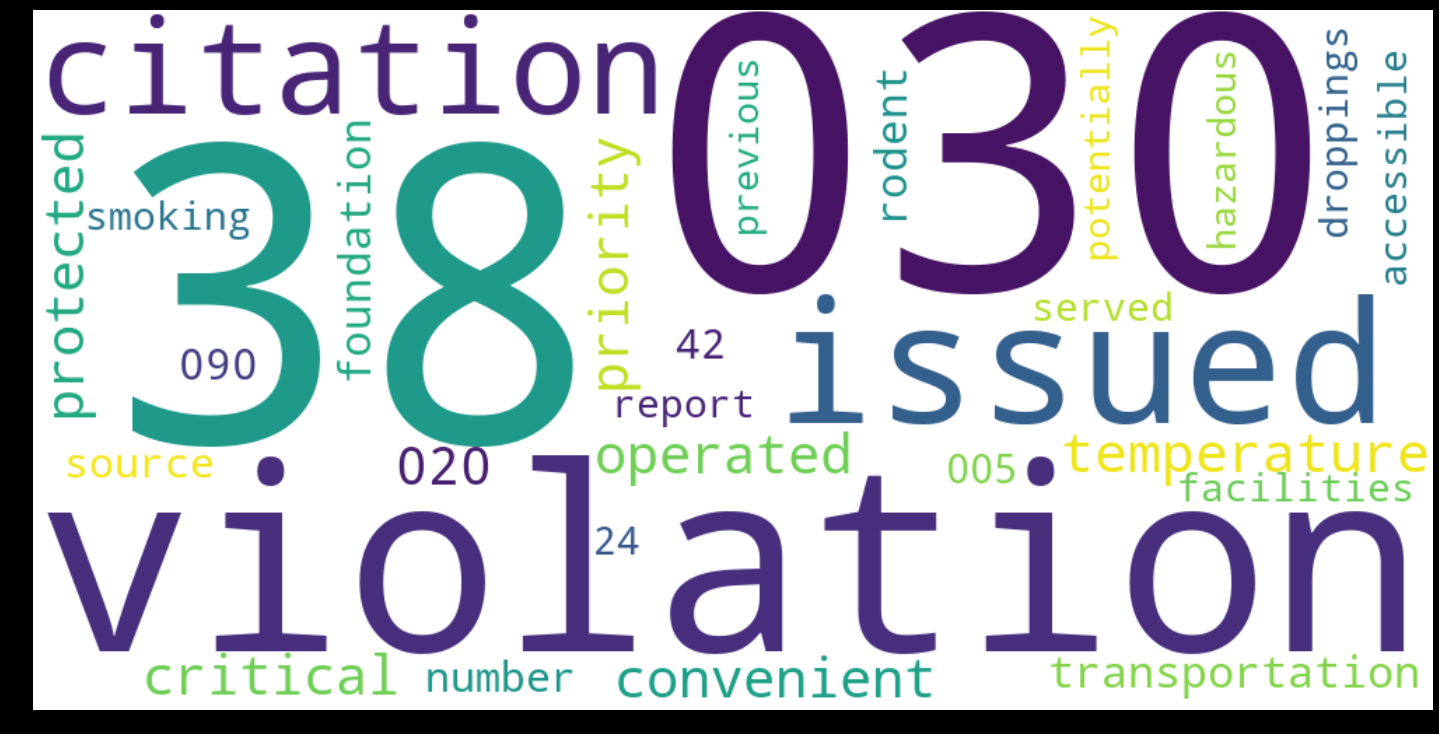

In [193]:
top_features_df = coefs_with_fns_df.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [194]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
30608,plumbing,3.775309
37238,supplied,3.615859
39905,vented,3.308691
30320,physical,3.179037
28596,non,2.654296
8888,55,2.575134
8631,51,2.436206
7774,32,2.431662
37289,surfaces,2.227718
33235,required,2.163933


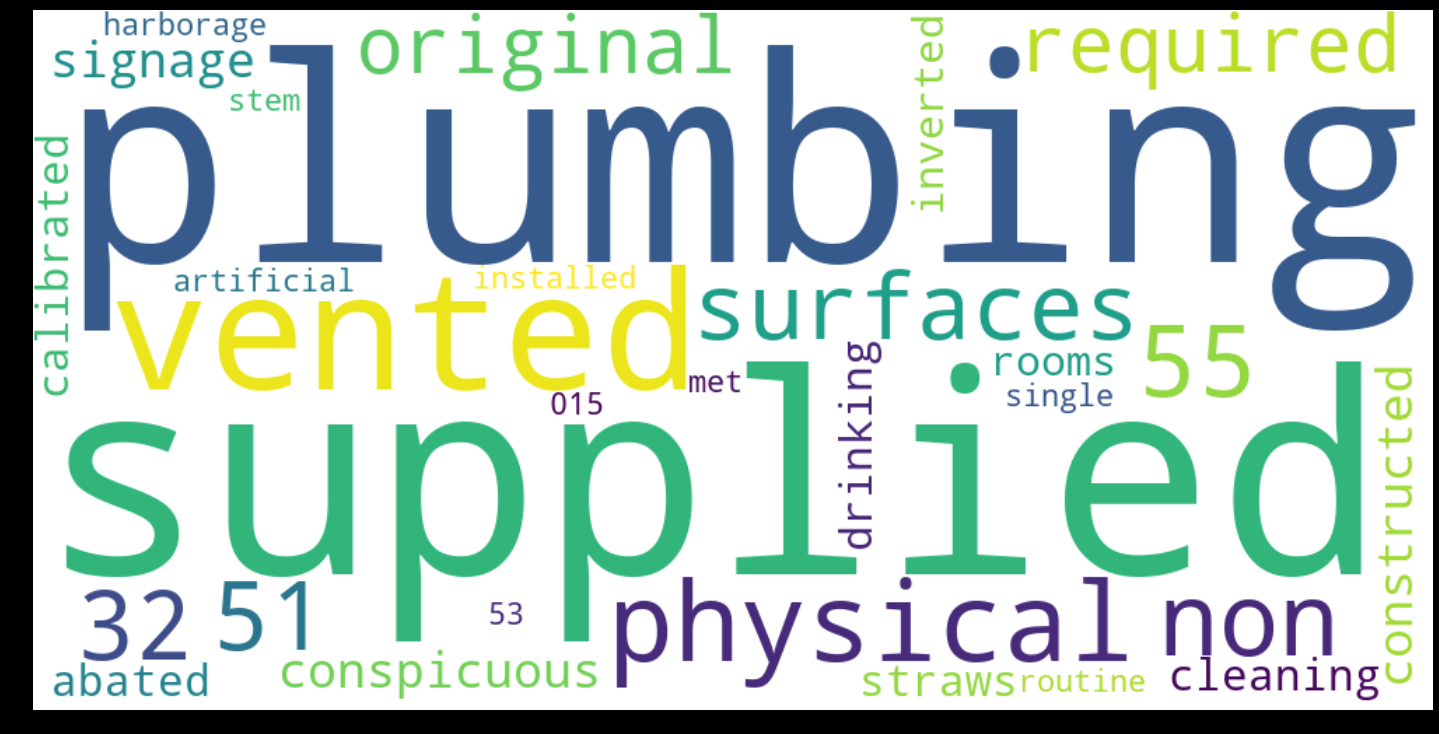

In [195]:
top_features_df = coefs_with_fns_df
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Support Vector Machine

In [196]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [197]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

C:\Users\manya\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Wall time: 17.4 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [199]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [119]:
#Countvect
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9398849448589444


In [200]:
#Tfidfvect
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9284045519632226


In [120]:
#CountVector
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22050
           1       0.89      0.88      0.88      8128
           2       0.91      0.88      0.89      9629

   micro avg       0.94      0.94      0.94     39807
   macro avg       0.92      0.92      0.92     39807
weighted avg       0.94      0.94      0.94     39807



In [201]:
#Tfidfvect
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22050
           1       0.87      0.84      0.85      8128
           2       0.89      0.86      0.87      9629

   micro avg       0.93      0.93      0.93     39807
   macro avg       0.91      0.90      0.90     39807
weighted avg       0.93      0.93      0.93     39807



In [121]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[21823   135    92]
 [  210  7142   776]
 [  405   775  8449]]


In [202]:
#Tfidfvect
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[21885    94    71]
 [  324  6820   984]
 [  422   955  8252]]


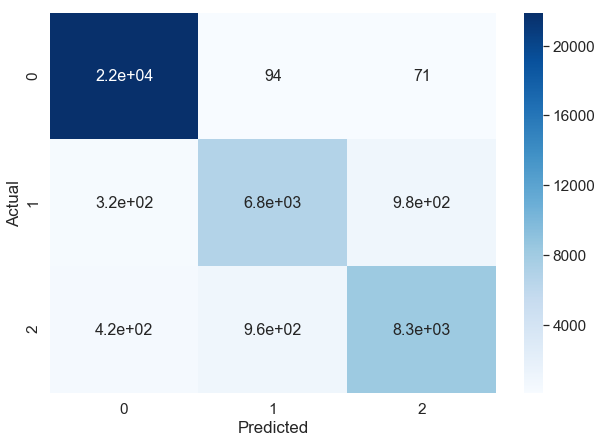

In [203]:
data = confusion_matrix(y_test, y_pred_class)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

SVM and LR are pretty close, but it looks like we get the best Test accuracy score using CountVector with Logistic Regression, so that is what I'll proceed with. 

## Part 5: Improving model performance

In [122]:
# show default parameters for CountVectorizer
countvectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.8, max_features=1000, min_df=0.2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [123]:
# remove English stop words
countvectorizer = CountVectorizer(stop_words='english')

In [124]:
# include n-grams
countvectorizer = CountVectorizer(ngram_range=(1, 3))

In [125]:
# ignore terms that appear in more than 50% of the documents
countvectorizer = CountVectorizer(max_df=0.5)

In [126]:
# only keep terms that appear in at least 2 documents
countvectorizer = CountVectorizer(min_df=2)

## Part 6.  Troubleshooting results
Focus on predictions with low confidence level

In [128]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [129]:
y_pred_prob = logreg.predict_proba(X_test_dtm)
y_pred_class = logreg.predict(X_test_dtm)

In [130]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [131]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [132]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(1168, 6)

In [134]:
results_review_df.head(10)

,Violations,results_flag,predicted,0-prob,1-prob,2-prob
8,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,1,1,1.250900e-08,0.567707,4.322933e-01
26,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,2,2,1.800408e-09,0.464661,5.353391e-01
43,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,0,0,5.163498e-01,0.289787,1.938635e-01
58,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,1,0,5.746623e-01,0.302400,1.229381e-01
154,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",2,0,5.307186e-01,0.469280,9.954393e-07
164,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,1,1,9.302069e-29,0.569582,4.304176e-01
187,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,1,1,7.352313e-04,0.512997,4.862681e-01
204,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,2,2,1.129109e-23,0.496584,5.034159e-01
312,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,1,2,4.762983e-11,0.492228,5.077717e-01
317,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,0,0,5.645512e-01,0.068698,3.667510e-01


To recap, I tried each vectorizing method and with each text classifier and chose the combination that resulted in the best accuracy and f-scores. After selecting CountVectorizer with Logistic Regression, I then fine tune the parameters. 